<a href="https://colab.research.google.com/github/leesuyee/mesoscale-connectivity-tutorial/blob/main/mesoscale_connectivity_coding_activity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mapping the Brain: Discovering How Brain Areas Connect

In this coding tutorial, we will analyze whole-brain anatomy data from the Allen Institute to identify patterns of connectivity between brain areas to better understand their function.

---

Feb 13, 2025

Allen Institute Education Activity

Su-Yee Lee, Mathew Summers, Nicholas Lusk, Saskia de Vries

**Dataset:** The dataset was collected as part of the [Thalamus in the Middle project](https://www.allenneuraldynamics.org/projects/neural-dynamics-in-multi-regional-circuits-with-thalamus-in-the-middle) at the Allen Institute for Neural Dynamics and is used to identify how different parts of the brain are connected, focusing on the frontal cortex and the thalamus.

Scientists image entire mouse brains using specialized microscopes capable of imaging large samples at single cell resolution. These microscopes create many 2D images, which are combined by computers into a 3D map of the brain. [Click here to see an example.](https://aind-neuroglancer-sauujisjxq-uw.a.run.app/#!%7B%22dimensions%22:%7B%22z%22:%5B0.000002%2C%22m%22%5D%2C%22y%22:%5B0.0000018%2C%22m%22%5D%2C%22x%22:%5B0.0000018%2C%22m%22%5D%2C%22t%22:%5B0.001%2C%22s%22%5D%7D%2C%22position%22:%5B1572.5%2C5318.5%2C3324.5%2C0.5%5D%2C%22crossSectionOrientation%22:%5B0.45008328557014465%2C0.49750208854675293%2C-0.49750208854675293%2C0.549916684627533%5D%2C%22crossSectionScale%22:17.869814483048113%2C%22projectionScale%22:16384%2C%22layers%22:%5B%7B%22type%22:%22image%22%2C%22source%22:%7B%22url%22:%22zarr://s3://aind-open-data/SmartSPIM_689238_2023-08-31_01-56-52_stitched_2023-09-12_07-47-44/image_tile_fusing/OMEZarr/Ex_445_Em_469.zarr%22%2C%22transform%22:%7B%22matrix%22:%5B%5B1%2C0%2C0%2C0%2C0%2C0%5D%2C%5B0%2C1%2C0%2C0%2C0%2C0%5D%2C%5B0%2C0%2C1%2C0%2C0%2C11%5D%2C%5B0%2C0%2C0%2C1%2C0%2C0%5D%2C%5B0%2C0%2C0%2C0%2C1%2C0%5D%5D%2C%22outputDimensions%22:%7B%22t%22:%5B0.001%2C%22s%22%5D%2C%22c%27%22:%5B1%2C%22%22%5D%2C%22z%22:%5B0.000002%2C%22m%22%5D%2C%22y%22:%5B0.0000018%2C%22m%22%5D%2C%22x%22:%5B0.0000018%2C%22m%22%5D%7D%7D%7D%2C%22localDimensions%22:%7B%22c%27%22:%5B1%2C%22%22%5D%7D%2C%22localPosition%22:%5B0.5%5D%2C%22tab%22:%22source%22%2C%22opacity%22:0.48%2C%22blend%22:%22additive%22%2C%22shader%22:%22#uicontrol%20vec3%20color%20color%28default=%5C%22#3f2efe%5C%22%29%5Cn#uicontrol%20invlerp%20normalized%5Cnvoid%20main%28%29%20%7B%5CnemitRGB%28color%20%2A%20normalized%28%29%29%3B%5Cn%7D%22%2C%22shaderControls%22:%7B%22color%22:%22#2f93fe%22%2C%22normalized%22:%7B%22range%22:%5B50%2C350%5D%2C%22window%22:%5B0%2C400%5D%7D%7D%2C%22name%22:%22Ex_445_Em_469%22%7D%2C%7B%22type%22:%22image%22%2C%22source%22:%22zarr://s3://aind-open-data/SmartSPIM_689238_2023-08-31_01-56-52_stitched_2023-09-12_07-47-44/image_tile_fusing/OMEZarr/Ex_488_Em_525.zarr%22%2C%22localDimensions%22:%7B%22c%27%22:%5B1%2C%22%22%5D%7D%2C%22localPosition%22:%5B0.5%5D%2C%22tab%22:%22rendering%22%2C%22opacity%22:0.51%2C%22blend%22:%22additive%22%2C%22shader%22:%22#uicontrol%20vec3%20color%20color%28default=%5C%22#58fea1%5C%22%29%5Cn#uicontrol%20invlerp%20normalized%5Cnvoid%20main%28%29%20%7B%5CnemitRGB%28color%20%2A%20normalized%28%29%29%3B%5Cn%7D%22%2C%22shaderControls%22:%7B%22normalized%22:%7B%22range%22:%5B300%2C700%5D%7D%7D%2C%22name%22:%22Ex_488_Em_525%22%7D%2C%7B%22type%22:%22image%22%2C%22source%22:%22zarr://s3://aind-open-data/SmartSPIM_689238_2023-08-31_01-56-52_stitched_2023-09-12_07-47-44/image_tile_fusing/OMEZarr/Ex_561_Em_593.zarr%22%2C%22localDimensions%22:%7B%22c%27%22:%5B1%2C%22%22%5D%7D%2C%22localPosition%22:%5B0.5%5D%2C%22tab%22:%22rendering%22%2C%22opacity%22:1%2C%22blend%22:%22additive%22%2C%22shader%22:%22#uicontrol%20vec3%20color%20color%28default=%5C%22#f15211%5C%22%29%5Cn#uicontrol%20invlerp%20normalized%5Cnvoid%20main%28%29%20%7B%5CnemitRGB%28color%20%2A%20normalized%28%29%29%3B%5Cn%7D%22%2C%22shaderControls%22:%7B%22normalized%22:%7B%22range%22:%5B100%2C1600%5D%7D%7D%2C%22name%22:%22Ex_561_Em_593%22%7D%2C%7B%22type%22:%22image%22%2C%22source%22:%22zarr://s3://aind-open-data/SmartSPIM_689238_2023-08-31_01-56-52_stitched_2023-09-12_07-47-44/image_tile_fusing/OMEZarr/Ex_639_Em_660.zarr%22%2C%22localDimensions%22:%7B%22c%27%22:%5B1%2C%22%22%5D%7D%2C%22localPosition%22:%5B0.5%5D%2C%22tab%22:%22rendering%22%2C%22opacity%22:1%2C%22blend%22:%22additive%22%2C%22shader%22:%22#uicontrol%20vec3%20color%20color%28default=%5C%22#f00050%5C%22%29%5Cn#uicontrol%20invlerp%20normalized%5Cnvoid%20main%28%29%20%7B%5CnemitRGB%28color%20%2A%20normalized%28%29%29%3B%5Cn%7D%22%2C%22shaderControls%22:%7B%22color%22:%22#ffffff%22%2C%22normalized%22:%7B%22range%22:%5B0%2C600%5D%7D%7D%2C%22name%22:%22Ex_639_Em_660%22%7D%5D%2C%22selectedLayer%22:%7B%22size%22:355%2C%22visible%22:true%2C%22layer%22:%22Ex_488_Em_525%22%7D%2C%22layout%22:%22yz%22%7D)* Each brain is then aligned to a standard reference map so that different brains can be compared.

A single brain dataset can contain hundreds of thousands of individual neurons. Manually finding all of these cells would take a long time, so scientists use computer vision models to automatically detect where each neurons appears in the images.

The main data you will work with in this tutorial are the locations of these detected cells. Each cell is recorded as a set of coordinates in 3D space, which tells us where it is in the brain. Because the datasets are aligned to a standard reference map, the coordinates can be used to determine which brain region each cell belongs to which aids in constructing maps of connections between brain areas.

**Experiment:** These experiments were designed to identify which brain areas send information to the frontal cortex, a region important for planning and decision-making.

Scientists use specially designed viruses to "label" neurons that are connected to each other. For example, when a virus injected into the frontal cortex, neurons that are connected to neurons in this region express a fluorescent protein that will glow when imaged with the specialized microscope.

**Goals:**
In this tutorial, we will work with the cell location data from these experiments to analyze patterns in connectivity across brain areas, and learn how data science helps researchers understand the brain.


*Further Resources: [Neuroglancer Tutorial](https://www.microns-explorer.org/ngl-instructions)

# Set up environment

Run the code cells below to install and import the packages and clone the github repo to import some of the data we'll be using.

**DO NOT RERUN THIS CELL**


In [ ]:
# install packages
!pip install s3fs==2026.1.0 pandas==2.2.2 brainglobe-atlasapi==2.3.0 matplotlib==3.10.0 numpy==2.0.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.8/201.8 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 85.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2026.1.0 which is incompatible.
datasets 4.0.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2026.1.0 which is incompatible.


In [ ]:
# import packages
import os
from pathlib import Path
import pandas as pd
import s3fs
import matplotlib.pyplot as plt
import numpy as np
from brainglobe_atlasapi import BrainGlobeAtlas

In [ ]:
# Clone github repo to access data folders
repo_url = "https://github.com/leesuyee/mesoscale-connectivity-tutorial.git" # github repo URL
repo_dir = "/content/mesoscale-connectivity-tutorial" # set up path

# Clone the repo if it hasn't been cloned yet
if not os.path.exists(repo_dir):
    print(f"Cloning repository from {repo_url}...")
    !git clone {repo_url} {repo_dir}
else:
    print(f"Repository already exists at {repo_dir}")

# Change working directory to repo root
os.chdir(repo_dir)
print("Cloned github repo" )

# Import Allen mouse atlas from data folder

# Path to the data folder
local_bg_dir = Path("/content/mesoscale-connectivity-tutorial/data/")

# Initialize atlas from the local folder
atlas = BrainGlobeAtlas(
    atlas_name="allen_mouse_25um",
    brainglobe_dir=local_bg_dir,
    check_latest=False  # disables network version check
)

# Check atlas shape
print(atlas.reference.shape)

Cloning repository from https://github.com/leesuyee/mesoscale-connectivity-tutorial.git...
Cloning into '/content/mesoscale-connectivity-tutorial'...
remote: Enumerating objects: 2649, done.
remote: Counting objects: 100% (1780/1780), done.
remote: Compressing objects: 100% (1769/1769), done.
remote: Total 2649 (delta 44), reused 1719 (delta 8), pack-reused 869 (from 3)
Receiving objects: 100% (2649/2649), 61.95 MiB | 17.43 MiB/s, done.
Resolving deltas: 100% (50/50), done.
Filtering content: 100% (848/848), 608.02 MiB | 29.35 MiB/s, done.
Cloned github repo
(528, 320, 456)


# Load data for a single brain

The `load_mouse` function (hidden below) loads the data from S3 storage and the local repo for a selected mouse brain. Pass the `mouse_ID`, a numerical ID associated with each mouse to identify the asset.

Let's use the `load_mouse` function and look at the data we have to work with.

In [ ]:
# @title Run hidden `load_mouse` function
# Class to load SmartSPIM data asset from S3
class load_data:
    """
    Minimal Colab-compatible loader for SmartSPIM data (CCF coordinates and region counts) streamed directly from S3

    Parameters
    ----------
    mouse_ID : str | int
        Mouse ID (e.g. 689305)

        bucket : str
        S3 bucket name (e.g. "s3://aind-open-data")

        anon : bool
        Whether to use anonymous credentials (e.g. True)

        prefer_stitched : bool
        Whether to prefer stitched data (e.g. True)

    Attributes
    ----------
    rootDir : str
        Resolved S3 path to the selected SmartSPIM dataset.

    quantPaths : dict[str, str]
        Mapping from imaging channel (e.g., ``"488"``) to the
        corresponding ``cell_count_by_region.csv`` file path.

    ccfCellsPaths : dict[str, str]
        Mapping from imaging channel to the corresponding
        ``transformed_cells.xml`` file path containing CCF
        coordinates.

    channels : list[str]
        Sorted list of available imaging channels discovered
        for the dataset.

    Methods
   ----------
   resolve_paths()
        Method to get path to whole brain volume data

    getCellsCCFdf(ch: list[str])
        Retrieves and formats CCF transformed coordinates of segmented cells into a DataFrame

    getcellcounts(ch: list[str])
        Imports the cell_counts_by_region.csv as a DataFrame


    """

    def __init__(
        self,
        mouse_ID: str | int,
        bucket: str = "s3://aind-open-data",
        anon: bool = True,
        prefer_stitched: bool = True,
    ):
        self.mouse_ID = str(mouse_ID)
        self.bucket = bucket
        self.fs = s3fs.S3FileSystem(anon=anon)
        self.prefer_stitched = prefer_stitched

        self._resolve_paths()

    # Path resolution

    def _resolve_paths(self):
      """
      Method to get path to whole brain volume data
      """
      roots = self.fs.ls(self.bucket)
      matches = [r for r in roots if self.mouse_ID in r]

      if not matches:
          raise FileNotFoundError(f"No datasets found for mouse_ID {self.mouse_ID}")

      if self.prefer_stitched:
          stitched = [r for r in matches if "stitched" in r.lower()]
          if len(stitched) == 1:
              self.rootDir = stitched[0]
          elif len(stitched) > 1:
              print(f"Successfully loaded data asset for {self.mouse_ID}.")
              self.rootDir = sorted(stitched)[-1]
          else:
              self.rootDir = matches[0]
      else:
          self.rootDir = matches[0]

      quant_dir = f"{self.rootDir}/image_cell_quantification"
      if not self.fs.exists(quant_dir):
          raise FileNotFoundError("image_cell_quantification directory not found")

      quant_paths = self.fs.glob(f"{quant_dir}/Ex*")

      self.quantPaths = {
          Path(p).name.split("_")[1]: f"{p}/cell_count_by_region.csv"
          for p in quant_paths
      }
      self.ccfCellsPaths = {
          Path(p).name.split("_")[1]: f"{p}/transformed_cells.xml"
          for p in quant_paths
      }

      self.channels = sorted(self.quantPaths.keys())

    # Cell coordinates in CCF

    def getCellsCCFdf(self, ch: list[str]):
        """
        Retrieves and formats CCF transformed coordinates of segmented cells into a DataFrame

        Parameters
        ----------
        ch : list[str]
            List of imaging channels to retrieve coordinates from (e.g., ["488", "561"])

        Returns
        -------
        dfs : pd.DataFrame
            DataFrame cwhere each row is a cell and each column is a coordinate:
            AP (anterior-posterior), DV(dorsal-ventral), ML(medial-lateral),
            with an additional "channel column indicating the channel of origin
        """
        ccfDim = [528, 320, 456] # Allen mouse 25um atlas
        dfs = []

        for channel in ch:
            if channel not in self.ccfCellsPaths:
                raise KeyError(f"Channel {channel} not found")

            with self.fs.open(self.ccfCellsPaths[channel], "rb") as f:
                df = pd.read_xml(
                    f,
                    xpath="//CellCounter_Marker_File//Marker_Data//Marker_Type//Marker",
                )

            # export data in XYZ order and rename columns to AP, DV, ML
            df = (
                df[["MarkerX", "MarkerY", "MarkerZ"]]
                .rename(
                    columns={
                        "MarkerX": "AP",
                        "MarkerY": "DV",
                        "MarkerZ": "ML",
                    }
                )
                .assign(channel=channel)
            )
            # Clip coordinates within specified dimensions
            df["AP"] = df["AP"].clip(0, ccfDim[0] - 1)
            df["DV"] = df["DV"].clip(0, ccfDim[1] - 1)
            df["ML"] = df["ML"].clip(0, ccfDim[2] - 1)

            dfs.append(df)

        return pd.concat(dfs, ignore_index=True)

    # Cell counts by region

    def getcellcounts(self, ch: list[str]):
        """
        Imports the cell_counts_by_region.csv (quantifiction of detected cells in brain regions) as a DataFrame

        Parameters
        ----------
        ch : list[str]
            List of imaging channels to retrieve coordinates from (e.g., ["488", "561"]

        Returns
        -------
        dfs : pd.DataFrame
            DataFrame where each row is a brain region cell count in a given channel
        """
        required_columns = [
            "ID", "Acronym", "Name", "Struct_Info", "Struct_area_um3",
            "Left", "Right", "Total",
            "Left_Density", "Right_Density", "Total_Density",
        ]

        # Initialize an empty list to hold DataFrames
        cell_counts_list = []

        for channel in ch:
            if channel not in self.quantPaths:
                print(f"Channel {channel} not found. Skipping this")
                continue

            # Load csv
            with self.fs.open(self.quantPaths[channel], "rb") as f:
                df = pd.read_csv(f)

                # Check if all required columns are present
                if set(required_columns).issubset(df.columns):
                  # Truncate the DataFrame to specific columns
                  cell_counts = df[required_columns]
                  # Add a new column indicating the channel
                  cell_counts = cell_counts.assign(channel=channel)
                  # Append to list
                  cell_counts_list.append(cell_counts)

                # Throw error if missing columns
                if not set(required_columns).issubset(df.columns):
                    # Change to 'continue' to skip this channel and proceed with the next
                    continue

            # Concatenate list into a single DataFrame
            if cell_counts_list:
              cell_counts_df = pd.concat(cell_counts_list, ignore_index=True)
            else:
            # return empty DataFrame if no data is found
              cell_counts_df = pd.DataFrame(columns = required_columns + ["channel"])

        return cell_counts_df

def load_metadata(
    csv_path: str,
    mouse_ID: str | int
    ) -> pd.DataFrame:

    df = pd.read_csv(csv_path)
    df["channel"] = df["channel"].astype(str) # change data type to match cell counts and cell coordinates dataframes

    df_mouse = df[df["subject_id"].astype(str) == str(mouse_ID)]
    if df_mouse.empty:
        raise ValueError(f"No metadata found for mouse_ID {mouse_ID}")

    return df_mouse

def add_injection_metadata(
    ccf_df: pd.DataFrame,
    metadata_df: pd.DataFrame
    ) -> pd.DataFrame:

  """
  Add injection parent information to cell counts and cell coordinates dataframes
  """

  # Group by channel and take the first inj_parent to ensure a unique index for mapping
  # This handles cases where a channel might have multiple inj_parent entries in metadata.
  inj_map = (
      metadata_df.groupby("channel")["inj_parent"].first()
  )

  return ccf_df.assign(
      inj_parent=ccf_df["channel"].map(inj_map)
  )


def load_mouse(
    mouse_ID: str | int,
    metadata_csv: str = "metadata/metadata_filtered.csv",
) -> dict[str, pd.DataFrame]:

    """
    High-level loader that returns fully packaged SmartSPIM data
    using all available channels in the dataset. Must have github repo cloned and mounted in colab.

    Parameters
    ----------
    mouse_ID : str | int
        Mouse ID (e.g. 689305)

    metadata_csv : str
        Path to the metadata CSV file

    Returns
    -------
    channels : list[str]
        List of available imaging channels

    ccf_df : pd.DataFrame
        DataFrame containing coordinates of segmented cells

    cell_counts_df : pd.DataFrame
        DataFrame containing cell counts by brain region

    metadata_df : pd.DataFrame
        DataFrame containing metadata for selected mouse ID

    """

    loader = load_data(mouse_ID)

    # Get channels in data asset
    channels = loader.channels

    if not channels:
        raise ValueError(f"No imaging channels found for mouse_ID {mouse_ID}")

    # Load raw data
    ccf_df = loader.getCellsCCFdf(channels)
    cell_counts_df = loader.getcellcounts(channels)

    # Load metadata
    metadata_df = load_metadata(metadata_csv, mouse_ID)

    # Add injection parent and subject id information from metadata
    ccf_df = add_injection_metadata(ccf_df, metadata_df)
    cell_counts_df = add_injection_metadata(cell_counts_df, metadata_df)

    return channels, ccf_df, cell_counts_df, metadata_df

In [ ]:
mouse_ID = 684812 # pre-selected mouse ID
[channels, cell_coords_df, cell_counts_df, metadata_df] = load_mouse(mouse_ID)

Successfully loaded data asset for 684812.


# Cell Coordinates

Using the `load_mouse` function, we've created a pd.DataFrame named `cell_coords_df` which contains the 3D coordinates of the detected cells in the dataset.The coordinates are in AP (anterior-posterior), DV (dorsal-ventral), ML(medial-lateral) axes (see schematic below for reference).

Note the `channel` and `inj_parent` columns. `channel` refers to the laser wavelength of the imaging channel that was used to take the image. The `inj_parent` column indicates the brain area in which the virus was injected, or the brain area that the detected cells are connected to.

to do - include something about multiplexing experiments and several fluorescent proteins can be used and thus many channels imaged...

change nomenclature of dataframe - delete channel? change inj_parent to inj_site

![apmldv](https://raw.githubusercontent.com/leesuyee/mesoscale-connectivity-tutorial/main/resources/apmldv.png)

Images adapted from Encyclopaedia Britannica 2010

In [ ]:
cell_coords_df

,AP,DV,ML,channel,inj_parent
0,406,71,258,445,MOs
1,419,72,273,445,MOs
2,421,77,272,445,MOs
3,430,74,270,445,MOs
4,433,77,229,445,MOs
...,...,...,...,...,...
833397,445,131,100,561,ACAd
833398,444,136,95,561,ACAd
833399,445,135,96,561,ACAd
833400,444,136,96,561,ACAd


# **Task:** How many unique injection sites are there in this dataset?

In [ ]:
cell_coords_df.inj_parent.unique()

# **Task:** How many cells are in the 445 channel/have MOs injection parent?

# Plot Heatmap of Cell Counts in Each Brain Area

One of the first things we should do when working with data is look at the data through plots! In this case, we want to know where are the cells spatially distributed across the brain? Let's visualize the data by plotting histograms of the cell coordinates embedded within the anatomical structures. Since this dataset is used to map connections between the thalamus and frontal cortex, we'll plot a section of the brain centered on the thalamus. Using the `atlas.get_structure_mask` function, we can also overlay the brain structure boundaries to help us identify where the cell targets are.

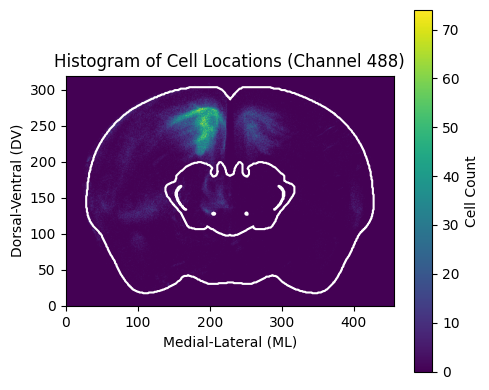

In [ ]:
# Plot heatmap of cell counts in the brain
ch = channels[1] # select a channel
plane =  250 # anterior-posterior slice to plot
window = 100 # slice window bounds
roiList = ["root", "TH"] # brain structures to plot

# set figure parameters
fig, ax = plt.subplots(figsize=(5, 4))

cellLocs = cell_coords_df[cell_coords_df.channel == ch]
# generate the histogram of cell coordinates
planeLocs = cellLocs.loc[(cellLocs['AP'] >= plane - window) & (cellLocs['AP'] <= plane + window), :] # filter cellLocs to coordinates within AP slice bounds

# calculate bins for histogram
xbins = np.arange(0, atlas.get_structure_mask("root").shape[2], 1)
ybins = np.arange(0, atlas.get_structure_mask("root").shape[1], 1)

# create histogram of ML, DV coordinates
hist, xedges, yedges = np.histogram2d(
    planeLocs[planeLocs['channel'] == ch]["ML"],
    planeLocs[planeLocs['channel'] == ch]["DV"],
    bins=(xbins, ybins))

# overlay the heatmap
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
heatmap = ax.imshow(
    hist.T,  # transpose because imshow expects (rows, cols)
    extent=extent,
    origin="upper",
    cmap="viridis",
    alpha=1)

# generate contour outlines for brain structures
for roi in roiList:
    roi_mask = atlas.get_structure_mask(roi) # creates a binary array the size of the brain, mask out brain structures of interest
    ax.contour(roi_mask[plane, :, :],
        levels=[0.5],
        colors="white",
        linewidths=1.5,
        origin="upper") # plotting features for structure outline

# add colorbar and labels
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label("Cell Count")
plt.title(f"Histogram of Cell Locations (Channel {ch})")
plt.xlabel("Medial-Lateral (ML)")
plt.ylabel("Dorsal-Ventral (DV)")

plt.tight_layout()
plt.show()

# **Task:** Try playing around with the `plane` and `window` parameters to adjust the location and thickness of the slice we plot or the roiList to outline different brain regions.

Alternatively - try plotting a different channel........

# Cell Counts Per Brain Area

The coordinates of each cell are used to identify the brain structure that each cells is in. The cell counts in each brain structure are tabulated and stored in a pd.DataFrame which we named `cell_counts_df`. Let's take a closer look.

| Column    | Description |
| -------- | ------- |
| ID  | number id of brain structure   |
| Acronym | shorthand name of brain structure     |
| Name | full name of brain structure     |
| Struct_Info    | mid = structure crosses the midline, hemi = structure disconnected across midline  |
| Struct_area_um3   | volume of brain structure    |
| Left    | left hemisphere cell counts    |
| Right    | right hemisphere cell counts   |
| Total    | total cell counts   |
| Left_Density    | density of cells in left hemisphere of brain structure  |
| Right_Density    | density of cells in right hemisphere of brain structure  |
| Total_Density    | density of cells in total brain structure   |
| channel    | channel name    |
| inj_parent  | brain structure injection site |

In [ ]:
cell_counts_df

,ID,Acronym,Name,Struct_Info,Struct_area_um3,Left,Right,Total,Left_Density,Right_Density,Total_Density,channel,inj_parent
0,997,root,root,mid,5.113271e+11,98427,22800,121227,3.849864e-07,8.917970e-08,2.370831e-07,445,MOs
1,8,grey,Basic cell groups and regions,hemi,2.312776e+11,97349,22574,119923,4.209185e-07,9.760566e-08,2.592621e-07,445,MOs
2,567,CH,Cerebrum,hemi,1.414069e+11,93998,20359,114357,6.647341e-07,1.439746e-07,4.043544e-07,445,MOs
3,688,CTX,Cerebral cortex,hemi,1.137573e+11,93728,20348,114076,8.239295e-07,1.788720e-07,5.014007e-07,445,MOs
4,695,CTXpl,Cortical plate,hemi,1.093212e+11,91238,20312,111550,8.345867e-07,1.858011e-07,5.101939e-07,445,MOs
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2509,129,V3,third ventricle,mid,1.139386e+09,1,0,1,1.755332e-09,0.000000e+00,8.776659e-10,561,ACAd
2510,140,AQ,cerebral aqueduct,mid,4.506497e+08,5,3,8,2.219019e-08,1.331411e-08,1.775215e-08,561,ACAd
2511,145,V4,fourth ventricle,mid,1.372785e+09,113,6,119,1.646289e-07,8.741355e-09,8.668510e-08,561,ACAd
2512,153,V4r,lateral recess,hemi,3.813698e+08,107,3,110,2.805676e-07,7.866381e-09,1.442170e-07,561,ACAd


# **Task:**

# What region has the highest total cell count with the inj_parent ACAd? What is the total?

# What region has the lowest?

# How many unique brain structures are there in a given channel?


# Compare Connectivity Across Brain Areas

To help us assess the connectivity across brain regions, we can use cell_counts_df to construct a connectivity matrix.  
    
First, filter the cell counts dataframe to cells within thalamic subregions.  Next, use pivot_table to tabulate the connectivity matrix. Rows = channels, columns = brain structure, values = total density (# cells/um3)

In [ ]:
# thalamic subregions of interest
roiList = ["PVT", "CL", "IMD", "IAD", "CM", "MD"]

# filter the df for cells within the roiList
filtered_cell_counts_df = cell_counts_df[cell_counts_df["Acronym"].isin(roiList)]

conn_mat = filtered_cell_counts_df.pivot_table(index = "inj_parent",
                                      columns = "Acronym",
                                      values = "Total_Density")

# Reorder the columns based on the roiList order
conn_mat = conn_mat[roiList]
conn_mat

Acronym,PVT,CL,IMD,IAD,CM,MD
inj_parent,,,,,,
ACAd,6.435932e-08,0.000001,1.122181e-07,0.000009,0.000001,3.506187e-07
MOs,1.989288e-07,0.000001,3.137007e-07,0.000002,0.000001,4.099593e-07


Let's plot the total densities across thalamic brain regions for the different injection sites as a heatmap. Below is a table with a brief description of the brain areas we're looking at:

| Acronym    | Full Name | Description |
| -------- | ------- | ----------|
| MOs  | secondary motor cortex | ...|
| ACAd  | dorsal anterior cingulate cotex| ...|
| ILA  | insular cortex | ...|
| PL  | prelimbic cortex  | ...|
| FRP  | frontal pole (cerebral cortex)  | ...|
| ORBm  | medial orbital cortex | ...|
| ORBvl  | ventrolateral orbital cortex| ...|
| ORBl  | lateral orbital cortex  | ...|
| AId  | dorsal agranular insular cortex | ...|
| PVT  | paraventricular nucleus | ...|
| CL  | central lateral nucleus | ...|
| IMD  | intermediodorsal nucleus  | ...|
| IAD  | interanterodorsal nucleus  | ...|
| CM  | centromedian nucleus  | ...|
| MD  | mediodorsal nucleus  | ...|

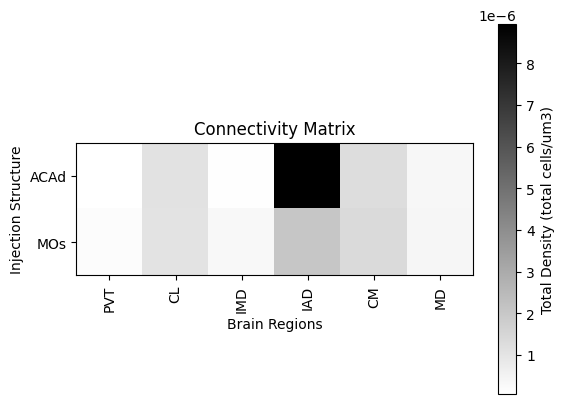

In [ ]:
# plot the connectivity matrix as a heatmap

plt.imshow(conn_mat, cmap="gray_r")
plt.colorbar(label="Total Density")
plt.xticks(ticks=range(len(conn_mat.columns)), labels=conn_mat.columns, rotation=90)
plt.yticks(ticks=range(len(conn_mat.index)), labels=conn_mat.index)
plt.title("Connectivity Matrix")
plt.xlabel("Brain Regions")
plt.ylabel("Injection Structure")
plt.show()

#**Discuss**

What do you notice about the plot?

Are there differences in how different thalamic areas target the cortex?

What do you notice about the structure of the connections?

Can you think of some hypotheses about the function of these different connections between thalamus and cortex?


to do - add some discussion that ties in the schematic below

# Compare across multiple datasets

Using 1 dataset, we can only make so many comparisons and only have 1 observation to base a claim off of. In order to answer questions about how brain areas are connected on the whole brain scale, we need look at data from multiple brain datasets and compare multiple injection sites. Something about use of datascience to help us with this...

Let's do that now. For time, we've generated a table of cell counts across many brain datasets (contained in the `/data/cell_counts_with_metadata.csv' file). Let's load the CSV as a pd.DataFrame and use our same code block for creating a pivot table and heat map of connectivity but this time on a larger dataset.

TO DO - adjust csv so that subject_id == mouse_ID and delete virus

In [ ]:
# to do - remove virus (?) and add subject id when loading data...
all_cell_counts = pd.read_csv("data/cell_counts_with_metadata.csv")
all_cell_counts

,Unnamed: 0,ID,Acronym,Name,Struct_Info,Struct_area_um3,Left,Right,Total,Left_Density,Right_Density,Total_Density,channel,subject_id,virus,inj_parent
0,0,997,root,root,mid,5.113271e+11,20277,36898,57175,7.931126e-08,1.443225e-07,1.118169e-07,488,679519,NaN,NaN
1,1,8,grey,Basic cell groups and regions,hemi,2.312776e+11,19584,36177,55761,8.467747e-08,1.564224e-07,1.205500e-07,488,679519,NaN,NaN
2,2,567,CH,Cerebrum,hemi,1.414069e+11,17026,26672,43698,1.204043e-07,1.886188e-07,1.545115e-07,488,679519,NaN,NaN
3,3,688,CTX,Cerebral cortex,hemi,1.137573e+11,16921,26278,43199,1.487465e-07,2.310005e-07,1.898735e-07,488,679519,NaN,NaN
4,4,695,CTXpl,Cortical plate,hemi,1.093212e+11,16864,26203,43067,1.542610e-07,2.396882e-07,1.969746e-07,488,679519,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42733,42733,129,V3,third ventricle,mid,1.139386e+09,8,45,53,1.404265e-08,7.898993e-08,4.651629e-08,488,721832,AAV-Syn-H2B-GFP,AId
42734,42734,140,AQ,cerebral aqueduct,mid,4.506497e+08,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,488,721832,AAV-Syn-H2B-GFP,AId
42735,42735,145,V4,fourth ventricle,mid,1.372785e+09,0,1,1,0.000000e+00,1.456892e-09,7.284462e-10,488,721832,AAV-Syn-H2B-GFP,AId
42736,42736,153,V4r,lateral recess,hemi,3.813698e+08,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,488,721832,AAV-Syn-H2B-GFP,AId


# **Task:** What structure has the highest Total in this dataset? Highest Total_Density?

In [ ]:
# to do count number of injections per inj_parent
# add pd.dataframe queries as exercises
# what are structures with highest total density

# **Discuss:**

Something about structure of connections - what do you think this will look like in the heatmap? What does this mean for the connections?

![connectivity_schematic](https://raw.githubusercontent.com/leesuyee/mesoscale-connectivity-tutorial/main/resources/connectivity_structure.png)

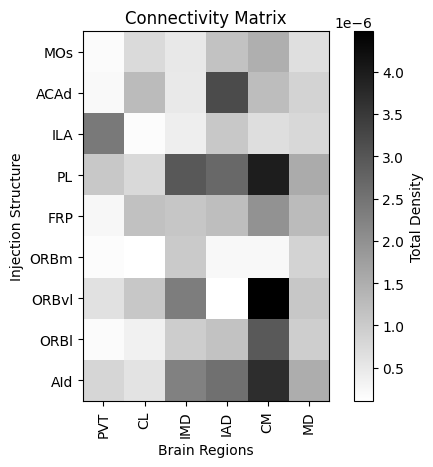

In [ ]:
# thalamic subregions of interest (leaf nodes)
roiList = ["PVT", "CL", "IMD", "IAD", "CM", "MD"]
inj_parent_list = ["MOs", "ACAd", "ILA", "PL", "FRP", "ORBm", "ORBvl", "ORBl", "AId"]

# filter the df for cells within the roiList
filtered_cell_counts_df = all_cell_counts[all_cell_counts["Acronym"].isin(roiList)]

conn_mat = filtered_cell_counts_df.pivot_table(index = "inj_parent",
                                      columns = "Acronym",
                                      values = "Total_Density")

# reorder conn_mat based on order of inj_parent_list
conn_mat = conn_mat.reindex(inj_parent_list)
conn_mat = conn_mat[roiList]

# plot the connectivity matrix as a heatmap

plt.imshow(conn_mat, cmap="gray_r")
plt.colorbar(label="Total Density")
plt.xticks(ticks=range(len(conn_mat.columns)), labels=conn_mat.columns, rotation=90)
plt.yticks(ticks=range(len(conn_mat.index)), labels=conn_mat.index)
plt.title("Connectivity Matrix")
plt.xlabel("Brain Regions")
plt.ylabel("Injection Structure")
plt.show()

In [ ]:
# potential to do - plot this in an anatomical representation? can i use brainglobe-heatmap here?